In [2]:
from mcresplot import cov
import numpy as np

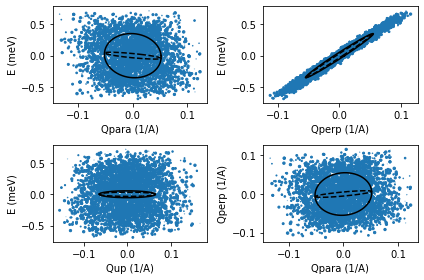

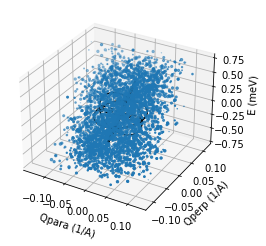

In [3]:
path = r'D:\5_Instrument\Mira_Bender\Mira_Bender_coldS\lapis_diffM_pol_bender_valued_res_monitor_20211025_105216/res_monitor_end.dat'

[Q, E, w] = cov.load_events_kikf(path)
[Qres, Q4, Qmean] = cov.calc_covar(Q, E, w, Qpara=[], Qperp=[])
[calcedellis, fwhmE] = cov.calc_ellipses(Qres)
cov.plot_ellipses('test.png', Q4, w, Qmean, calcedellis)

In [ ]:
# Modified plot_ellipses in cov.py for colorful subplots
options = {
	"verbose" : False,		# console outputs
	"plot_results" : True,#True,		# show plot window
	"plot_neutrons" : True,#True,		# also plot neutron events
	"centre_on_Q" : False,		# centre plots on Q or zero?
	"ellipse_points" : 128,		# number of points to draw ellipses
	"symsize" : 32.,
	"dpi" : 600,

	# column indices in ki,kf files
	"ki_start_idx" : 0,		# start index of ki 3-vector
	"kf_start_idx" : 3,		# start index of kf 3-vector
	"wi_idx" : 9,			# start index of ki weight factor
	"wf_idx" : 10,			# start index of kf weight factor

	# column indices in Q,E files
	"Q_start_idx" : 0,
	"E_idx" : 3,
	"w_idx" : 4,
}

def plot_ellipses_xu_sub(Q4, w, Qmean, ellis, ellidx=0, ax=None): # Plot with color representing the intensity
	try:
		import matplotlib.pyplot as plot
		from scipy import stats
		from matplotlib import cm
	except ImportError:
		print("Matplotlib could not be imported!")
		exit(-1)

	thesymsize = options["symsize"] * w
	themarker = "."
	kde = stats.gaussian_kde(Q4.T,weights=w) # this fun only accept 3 by x array
	density = kde(Q4.T).reshape([1,-1])
	density= (density-density.min()) / density.ptp()

	ellfkt = lambda rad, rot, phi, Qmean2d : \
		np.dot(rot, np.array([ rad[0]*np.cos(phi), rad[1]*np.sin(phi) ])) + Qmean2d

	# 2d plots
	if ax==None:
		fig, ax = plot.subplots()

	num_ellis = len(ellis)
	coord_axes = [[0,3], [1,3], [2,3], [0,1]]
	coord_names = ["Qpara (1/A)", "Qperp (1/A)", "Qup (1/A)", "E (meV)"]

	ellplots = []

	QxE = np.array([[0], [0]])

	if options["centre_on_Q"]:
		QxE = np.array([[Qmean[coord_axes[ellidx][0]]], [Qmean[coord_axes[ellidx][0]]]])

	phi = np.linspace(0, 2.*np.pi, options["ellipse_points"])

	ell_QxE = ellfkt(ellis[ellidx]["fwhms"]*0.5, ellis[ellidx]["rot"], phi, QxE)
	ell_QxE_proj = ellfkt(ellis[ellidx]["fwhms_proj"]*0.5, ellis[ellidx]["rot_proj"], phi, QxE)
	ellplots.append({"sliced":ell_QxE, "proj":ell_QxE_proj})


	subplot_QxE = ax
	subplot_QxE.set_xlabel(coord_names[coord_axes[ellidx][0]])
	subplot_QxE.set_ylabel(coord_names[coord_axes[ellidx][1]])
	if len(Q4.shape)==2 and len(Q4)>0 and len(Q4[0])==4:
		subplot_QxE.scatter(Q4[:, coord_axes[ellidx][0]], Q4[:, coord_axes[ellidx][1]], marker=themarker, s=thesymsize)
		subplot_QxE.scatter(Q4[:, coord_axes[ellidx][0]], Q4[:, coord_axes[ellidx][1]], marker='.', s=thesymsize, c=density, cmap=cm.jet)
	subplot_QxE.plot(ell_QxE[0], ell_QxE[1], c="black", linestyle="dashed")
	subplot_QxE.plot(ell_QxE_proj[0], ell_QxE_proj[1], c="black", linestyle="solid")
